In [1]:
import sys
sys.path.append('/home/s/seanmacb/pkgs')
import myutils_ar.myutils as myu
import eo_pipe
import lsst.daf.butler as daf_butler
from lsst.obs.lsst import LsstCam, LsstTS8
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

from mpl_toolkits.axes_grid1 import make_axes_locatable
import lsst.geom
from lsst.afw import cameraGeom
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib') 
import pandas as pd
import matplotlib.ticker as ticker
from scipy.stats import norm
from matplotlib.ticker import FormatStrFormatter
import run_six_utils as rsu

In [2]:
# For Run 6, we'll use the '/repo/ir2' butler repository.  We've analyzed the Run 5 data using '/repo/main'.
repo = '/repo/ir2'
# The shifters will run the cp_pipe and eo_pipe pipelines using the lsstccs group account.  For our setups,
# environment variables will be used to specify the runs to analyze and the weekly version of the LSST stack
# to run.  The collection names of the outputs will be composed of the operator, run number, and weekly version.
operator = 'lsstccs'
acq_runs = ['13401','13550']  # Run 6, run 6b.
weeklys = ['w_2023_24','w_2023_41']

In [3]:
dstypes = ('bright_defects_results', 'dark_defects_results')

In [ ]:
# We use the collection naming scheme to find all of the chained collections for an eo_pipe analysis of 
# the specified run.  For our dataset queries, we'll use these collections.
butler = daf_butler.Butler(repo)
for run_iter in range(len(acq_runs)):
    acq_run,weekly = acq_runs[run_iter],weeklys[run_iter]
    collections = butler.registry.queryCollections(f"u/{operator}/eo_*_{acq_run}_{weekly}",
                                                   collectionTypes=daf_butler.CollectionType.CHAINED)
    # for item in collections:
    #     print(item)
    # print()

    amp_data = eo_pipe.get_amp_data(repo, collections)
    
    # plt.figure(figsize=(9, 9))
    # ax = plt.gca()
    # eo_pipe.plot_focal_plane(ax, amp_data['read_noise'], z_range=(0, 20),title=weekly);

    # plt.show()

# plt.close()

In [ ]:
# Because of how the parallelization works with LSST middleware, some of the pipeline algorithms produce
# output separate data frames for each CCD.  Other algorithms work on all of the CCDs in one process, so 
# produce a single data frame for the entire focal plane.
#
# Here we loop over the datasets and print out the .info() for the datasets that are data frames.  Some
# of the datasets return zero references since they are derived from the PTC analysis in cp_pipe, and
# that pipeline was run on the densely sampled PTC data in run 13144.

butler = daf_butler.Butler(repo, collections=collections)

for i, dstype in enumerate(dstypes, 1):
    refs = list(set(butler.registry.queryDatasets(dstype, findFirst=True).expanded()))
    print(i, dstype, len(refs), end='  ')
    if not refs:  # No data products found for this dataset type for this run.
        print()
        continue
    ds = butler.get(refs[0])
    if isinstance(ds, pd.DataFrame):
        print(ds.info())
    print()



In [ ]:
df_dict = {}
butler = daf_butler.Butler(repo)
for run_iter in range(len(acq_runs)):
    acq_run,weekly = acq_runs[run_iter],weeklys[run_iter]
    collection = butler.registry.queryCollections(f"u/{operator}/eo_*_{acq_run}_{weekly}",
                                                   collectionTypes=daf_butler.CollectionType.CHAINED)
    df_dict[run_iter] = myu.eopipe_DictToDfz(eo_pipe.get_amp_data(repo,collection)) # For each run

In [ ]:
for k in [0,1]:
    df_dict[k]["Detector_Number"] = rsu.getDetectorNumber(df_dict[k]["BAY_SLOT"])
    df_dict[k]["Manufacturer"] = rsu.get_serial_from_number(df_dict[k]["Detector_Number"])

In [ ]:
rsu.get_serial_from_number([4])[0]

## On the x_pixels being funneled into x_columns

- two row subplot
- x axis detector (or amp) #
- y axis will be x_pixels / x_columns

In [ ]:
fig,axs = plt.subplots(2,1,figsize=[10,6])

identifiers = ['BRIGHT_COLUMNS', 'BRIGHT_PIXELS','DARK_COLUMNS', 'DARK_PIXELS']

for iter in range(len(df_dict)):
    axs[iter].scatter(df_dict[iter]["BAY"],df_dict[iter][identifiers[2*iter+1]]/df_dict[iter][identifiers[2*iter]])
    axs[iter].set_ylabel("Counts for \npixels/columns\n for "+identifiers[2*iter][:5])

plt.show()

In [ ]:
fig,axs = plt.subplots(2,1,figsize=[10,6])

identifiers = ['BRIGHT_COLUMNS', 'BRIGHT_PIXELS','DARK_COLUMNS', 'DARK_PIXELS']

for iter in range(len(df_dict)):
    axs[iter].scatter(df_dict[iter]["BAY"],df_dict[iter][identifiers[2*iter+1]],c="red",marker="+")
    twin = axs[iter].twinx()
    twin.scatter(df_dict[iter]["BAY"],df_dict[iter][identifiers[2*iter]],c="blue",marker="x")
    axs[iter].set_ylabel("Counts for \npixels/columns\n for "+identifiers[2*iter+1])
    twin.set_ylabel("Counts for \npixels/columns\n for "+identifiers[2*iter])
    # axs[iter].semilogy()
    twin.semilogy()
    

plt.show()

It doesn't appear that the columns and pixels are uncorrelated - lets use the direct images to verify

In [ ]:
interesting_detectors = np.unique([0, 20, 27, 65, 193, 194, 51, 55, 119, 127, 194]) # from AmpDataStatistics.ipynb

# Look at bias and flats with and without bright and dark defects, for both columns and pixels

In [ ]:
file_names = np.array([['u/lsstccs/dark_13401_w_2023_24','u/lsstccs/flat_13401_w_2023_24',
                        'u/lsstccs/bias_13401_w_2023_24','u/lsstccs/defects_13401_w_2023_24'],
                       ['u/lsstccs/dark_13550_w_2023_41','u/lsstccs/flat_13550_w_2023_41',
                        'u/lsstccs/bias_13550_w_2023_41','u/lsstccs/defects_13550_w_2023_41']]) # dark, flat, bias, defect

run_label = ['Run 6','Run 6b']

image_type = [": dark image",": flat image",": bias image",": bias with defect mask"]

In [ ]:
# What do we want here: a 5x2 fig, 
# with each row being a different mask of ['BRIGHT_COLUMNS', 'BRIGHT_PIXELS','DARK_COLUMNS', 'DARK_PIXELS'], and no mask
# Each column represents run 6 or 6b

In [ ]:
collections = 'LSSTCam/raw/all,LSSTCam/calib'.split(",") # Defining collections (that are ignored by below kernel)
butler = daf_butler.Butler(repo,collections=collections) # Initializing a butler with the ir2 path and the above collections
registry = butler.registry # converting the butler to a RegistryShim to query the datatypes

In [ ]:
# list(registry.queryCollections('*13401*')) # Querying to find collections that have 13550 in their paths

In [ ]:
def_type = ["eo_dark_defects","eo_bright_defects"]
dataset_type = ["eoDarkDefects","eoBrightDefects"]
img_type = ["flat","bias","dark"]
run_number = ["13401_w_2023_24","13550_w_2023_41"]

base_dir = "u/lsstccs/"

In [ ]:
for detector in interesting_detectors: # A new figure

    fig = 'mtv'
    plt.close(fig)
    fig = plt.figure(fig)
    
    fig,axs = plt.subplots(2,3,figsize=[15,10],sharex=True,sharey=True) # what these params?
    fig.suptitle("Detector {var}, {var2}".format(var=detector,var2=rsu.get_serial_from_number([detector])[0]))
    col_iter = 0
    for img in img_type: # Populating a different column
        row_iter = 0
        for run in run_number: # populating a different row
            collection = base_dir+img+"_"+run
            kwargs={
                "datasetType": img,
                "collections": collection,
                "where":
                """
                instrument='LSSTCam' and 
                detector = {var}
                """.format(var=detector)
                }
                
            datasetRefs = list(registry.queryDatasets(**kwargs))
            image = butler.get(datasetRefs[0])
            
            '''
            # TESTING HERE
            for items in datasetRefs:
                print(items)
            '''
            # Call the the fig her
            ax = axs[row_iter,col_iter]
            
            disp = afwDisplay.Display(fig)
            disp.scale('asinh', 'zscale', Q=8)
            
            rsu.formatter(disp)
            plt.sca(ax)
            disp.mtv(image, title=run[:5]+": "+img)

            row_iter+=1
        col_iter +=1
    fig.tight_layout()
    # plt.show()
    fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/Defect_comp/detector_{var}.pdf".format(var=detector),dpi=180)
    fig.clear()
    plt.close(fig)
del row_iter,col_iter,ax

In [ ]:
# It looks like there's two darks in 6b - any reason for this?

In [ ]:
# Also, can't find eoDarkDefects - the collection was being queried in a strange way

# Two detector comparison

In [ ]:
# detector_nums = [77,94]

def_type = ["eo_dark_defects","eo_bright_defects"]
dataset_type = ["eoDarkDefects","eoBrightDefects"]
img_type = ["flat","bias","dark"]
run_number = ["13401_w_2023_24","13550_w_2023_41"]

base_dir = "u/lsstccs/"

collections = 'LSSTCam/raw/all,LSSTCam/calib'.split(",") # Defining collections (that are ignored by below kernel)
butler = daf_butler.Butler('/repo/ir2',collections=collections) # Initializing a butler with the ir2 path and the above collections
registry = butler.registry

In [ ]:
detector1,detector2 = 37,0
rsu.two_detector_figure(detector1,detector2,base_dpi=200,tight=True,save=True,
                    path='/home/s/seanmacb/Run6Comparisons/Figures/TwoDetectorComps/detector_{var1}_{var2}.jpg'.format(var1=detector1,var2=detector2))

# Detector edge figure

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

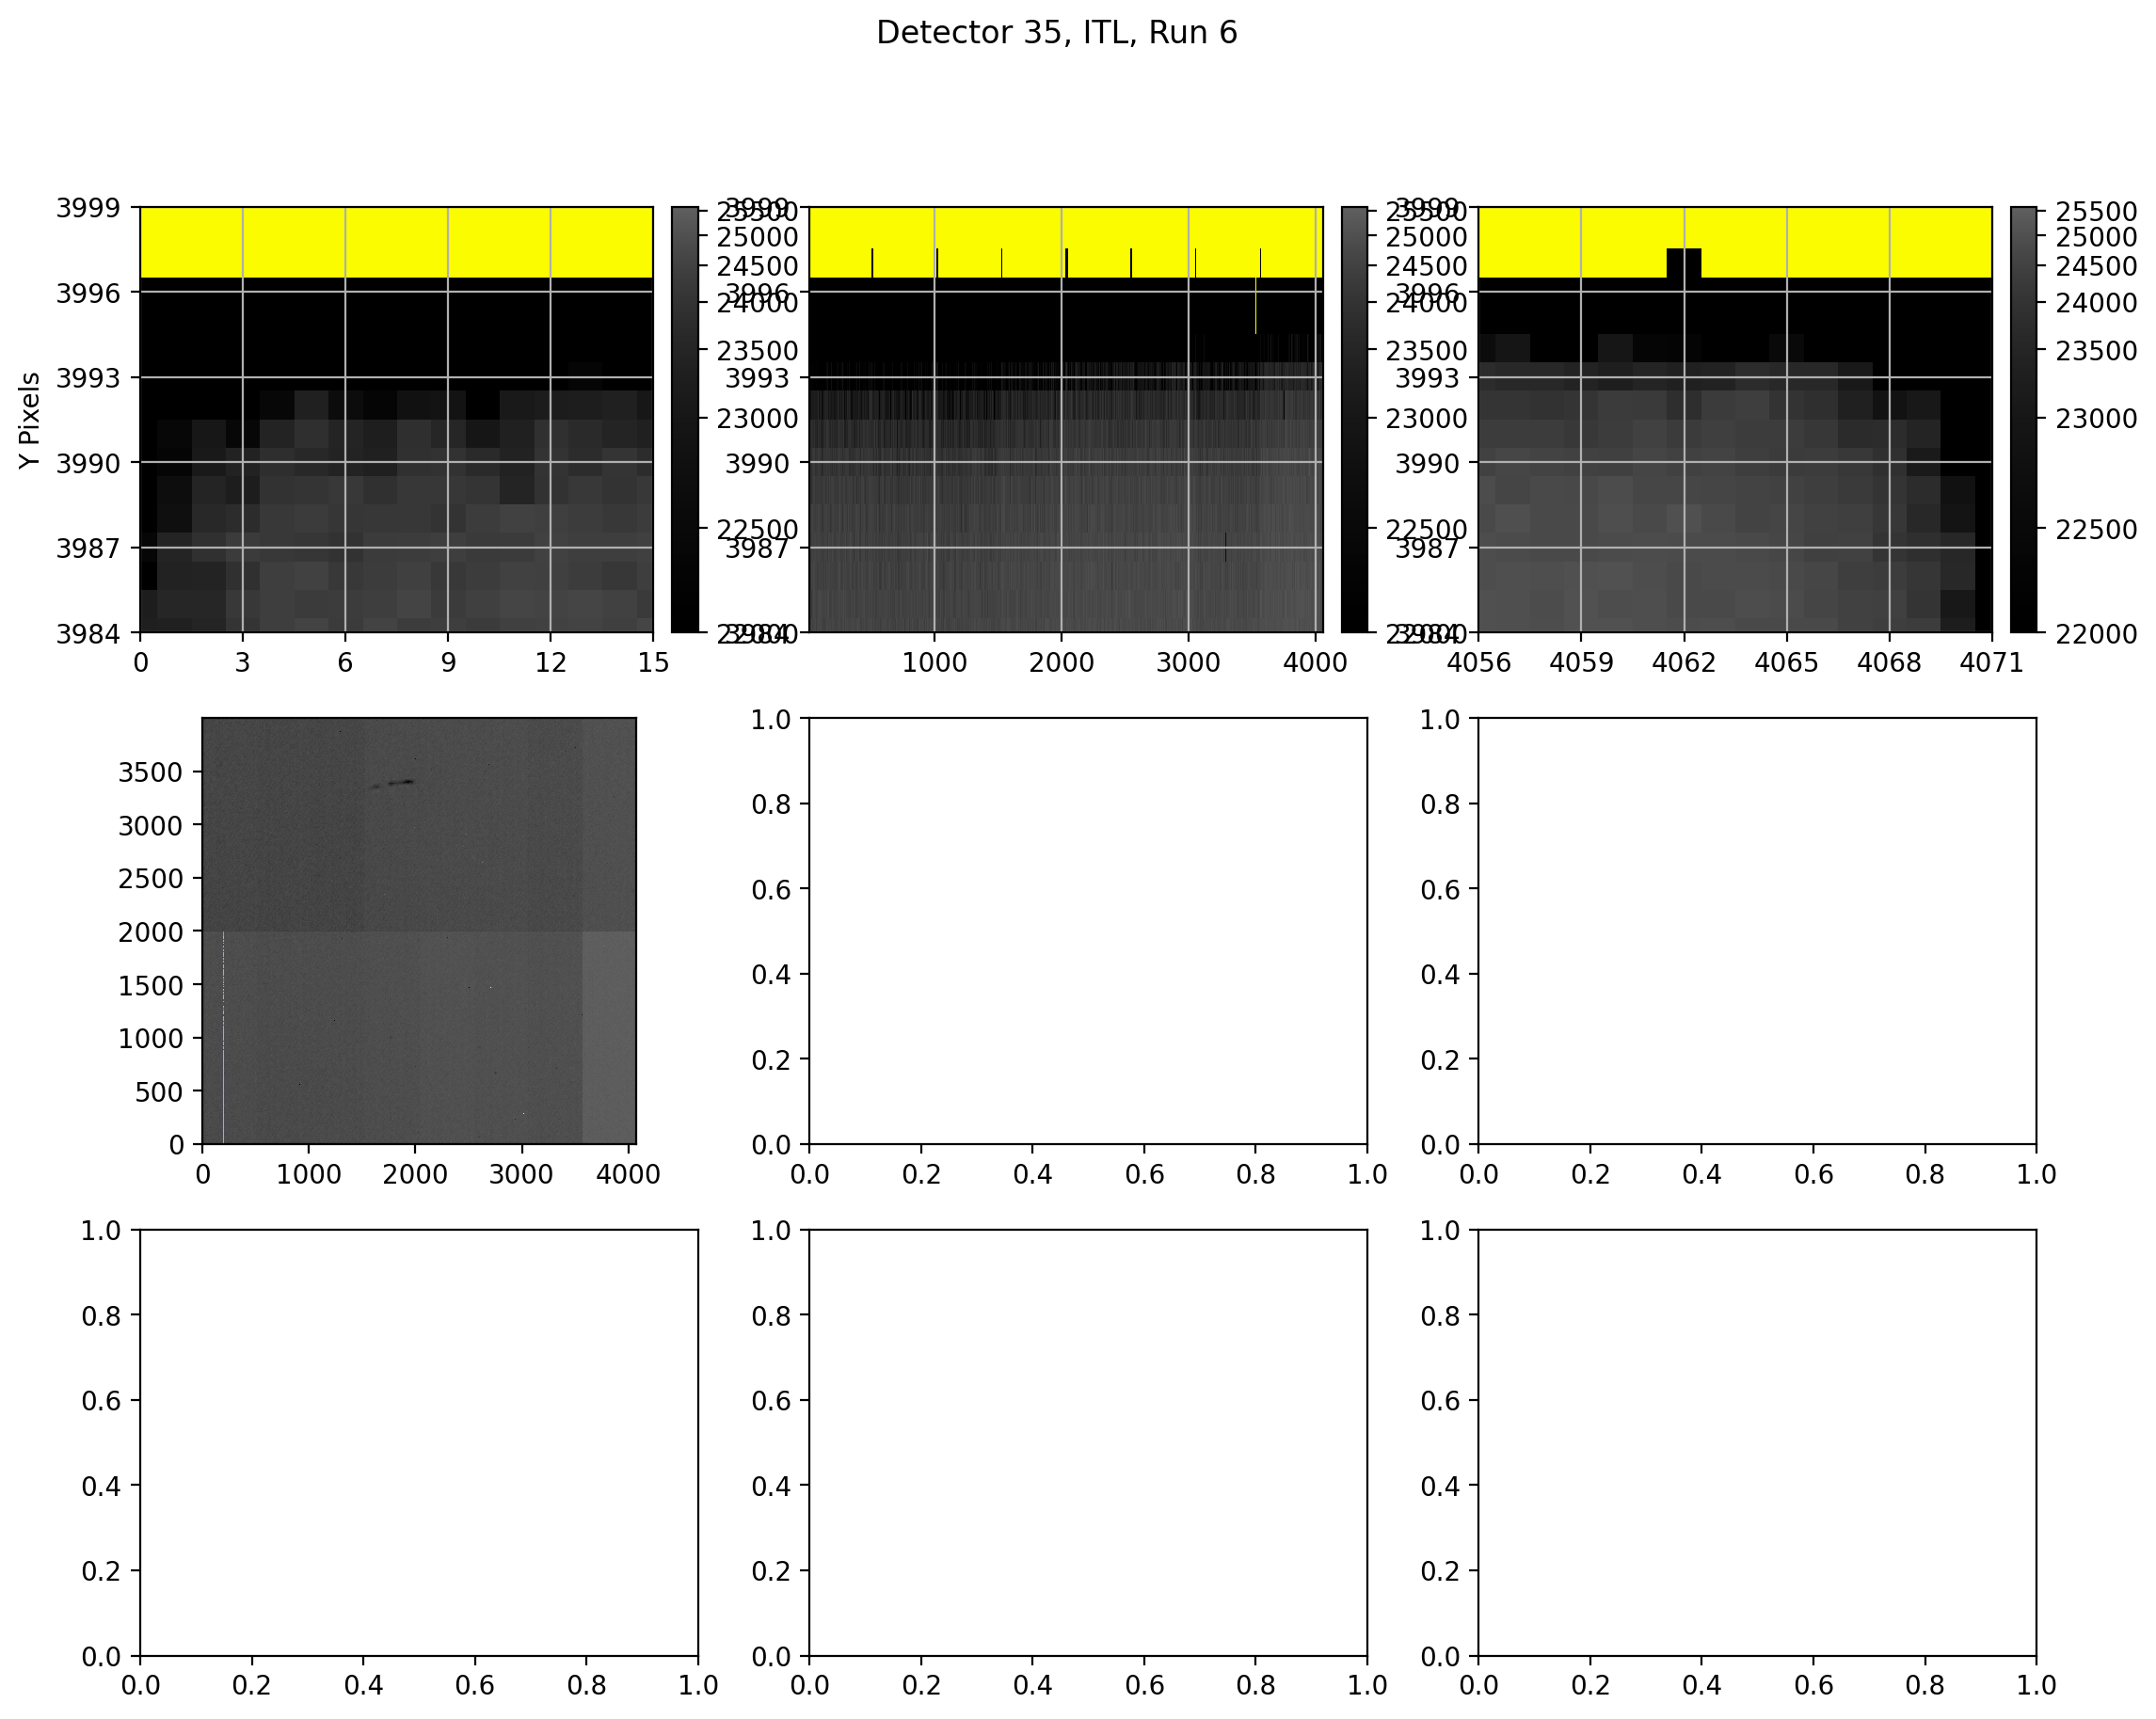

In [6]:
for mask_bool in [True,False]: # Should run in ~1 hour
    for run_numbah in ["6","6b"]:
        if run_numbah=="6":
            run_str = "13401_w_2023_24"
        elif run_numbah=="6b":
            run_str = "13550_w_2023_41"
        else:
            print("error!")
        for detector in np.arange(0,205,step=5): # runs in ~17 mins
            rsu.edge_detector(detector=detector,
                              edge_buffer=15,
                              tight=True,
                              save=True,
                              tick_sep=3,
                              run_number=run_str,
                              path='/home/s/seanmacb/Run6Comparisons/Figures/PictureFrameFigures_{var4}/{var2}/Run{var3}/detector_{var1}.jpg'.format(var1=detector,var2=rsu.get_serial_from_number([detector])[0],var3=run_numbah,var4=rsu.MaskBool(mask_bool)),
                              maskTransparency=0.5,
                              base_dpi=200,
                              show=False,
                              showmask=mask_bool,
                              img_type='flat',
                              run_numbah=run_numbah)
            print("Finished detector",detector,"for run",run_numbah,"and mask",mask_bool)

In [7]:
for mask_bool in [True,False]: # Should run in ~1 hour - sets if a mask is present or not
    for run_numbah in ["6"]:
        if run_numbah=="6":
            run_str = "13401_w_2023_24"
        elif run_numbah=="6b":
            run_str = "13550_w_2023_41"
        else:
            print("error!")
        for detector in [35,36]: # runs in ~17 mins
            rsu.edge_detector(detector=detector,
                              edge_buffer=15,
                              tight=True,
                              save=True,
                              tick_sep=3,
                              run_number=run_str,
                              path='/home/s/seanmacb/Run6Comparisons/Figures/PictureFrameFigures_{var4}/{var2}/Run{var3}/detector_{var1}.jpg'.format(var1=detector,var2=rsu.get_serial_from_number([detector])[0],var3=run_numbah,var4=rsu.MaskBool(mask_bool)),
                              maskTransparency=0.5,
                              base_dpi=200,
                              show=False,
                              showmask=mask_bool,
                              img_type='flat',
                              run_numbah=run_numbah)
            print("Finished detector",detector,"for run",run_numbah,"and mask",mask_bool)

Finished detector 35 for run 6 and mask True
Finished detector 36 for run 6 and mask True
Finished detector 35 for run 6 and mask False
Finished detector 36 for run 6 and mask False


<Figure size 640x480 with 0 Axes>

# Histogram over entire image plane

In [2]:
img = ['flat']
run = ["13401_w_2023_24","13550_w_2023_41"]
detector = 110

In [3]:
# MakeHistogram(img,run,detector,run_num,face_color='#2ab0ff',bin_num=100,edgecolor='#e0e0e0',lw=0.5,alpha=0.7,xlim=(0,5E4),y_ax='linear',ylim=(1E-10,1E-3),fit_norm=True,n_sig=1)

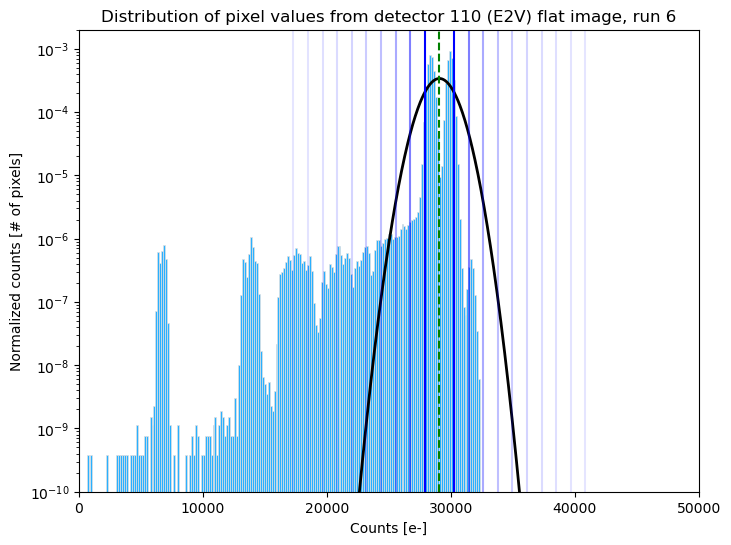

In [4]:
rsu.MakeHistogram(img[0],run[0],detector,"6",bin_num=200,alpha=1,lw=0.5,
                  y_ax='log',ylim=[1E-10,2E-3],fit_norm=True,n_sig=10)

# Histogram over single axis

In [8]:
fig = rsu.generate1DStatistics_oneDetector(img,run[0],30,'x',norm=True,edge=False,midline=False,ylim=[0.7,1.02])
# fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/FlatPictureFrames/ITL_example.jpg",dpi=200)

TypeError: can only concatenate str (not "list") to str

# run `rsu.statisticsHandler` on all detectors of a certain type
- start with all detectors, but try to also look at a subset of detectors not on edge rafts

In [4]:
# run_nums = ["13162", "13505", "13391"]

# 13162 - only in Alex's directoyu
# 13505 - run = 13505_w_2023_41
# 13391 - run = 13391_w_2023_24

repo_path = "/repo/ir2" # The path where the data taken in the ir2 cleanroom is stored
collections = 'LSSTCam/raw/all,LSSTCam/calib'.split(",") # Defining collections (that are ignored by below kernel)
butler = daf_butler.Butler(repo_path,collections=collections) # Initializing a butler with the ir2 path and the above collections
registry = butler.registry # converting the butler to a RegistryShim to query the datatypes

# for r in [run_nums[2]]:
#     tmp = list(registry.queryCollections('*{}*'.format(r))) # Querying to find collections that have 13550 in their paths
#     for entry in tmp:
#         print(entry)
#     print()

In [5]:
img= 'flat'
run = ['13391_w_2023_24','13401_w_2023_24','13505_w_2023_41', '13550_w_2023_41']

save=False
open= True

In [6]:
for r in run:
    base_dir = '/home/s/seanmacb/Run6Comparisons/Data/Roll-off/Median_fixed/{}/'.format(r)
    
    if save:
        E2V_Normed_x,ITL_Normed_x,E2V_Normed_x_std,ITL_Normed_x_std = rsu.getAllCals(img,r,axis='x',verbose=True,median=True) # Binned along x for all detectors
        E2V_Normed_y,ITL_Normed_y,E2V_Normed_y_std,ITL_Normed_y_std = rsu.getAllCals(img,r,axis='y',verbose=True,median=True) # binned along y for non-edge detectors
        E2V_Normed_y_edge,ITL_Normed_y_edge,E2V_Normed_y_edge_std,ITL_Normed_y_edge_std = rsu.getAllCals(img,r,axis='y',edge=True,verbose=True,median=True) # This should only give the edge detectors in ITL - check by subtracting E2V in y from the E2V in the above line
        
        np.savetxt(base_dir+"E2Vdata_x.txt",E2V_Normed_x)
        np.savetxt(base_dir+"ITLdata_x.txt",ITL_Normed_x)
        np.savetxt(base_dir+"E2Vdata_y.txt",E2V_Normed_y)
        np.savetxt(base_dir+"ITLdata_y.txt",ITL_Normed_y)
        np.savetxt(base_dir+"ITLdata_y_edge.txt",ITL_Normed_y_edge)
        # Add the std
        np.savetxt(base_dir+"ITLdata_y_std_edge.txt",ITL_Normed_y_edge_std)
        np.savetxt(base_dir+"E2Vdata_y_std.txt",E2V_Normed_y_std)
        np.savetxt(base_dir+"ITLdata_y_std.txt",ITL_Normed_y_std)
        np.savetxt(base_dir+"ITLdata_y_std.txt",ITL_Normed_x_std)
        np.savetxt(base_dir+"E2Vdata_x_std.txt",E2V_Normed_x_std)
    
    if open:
        E2V_Normed_x = np.loadtxt(base_dir+"E2Vdata_x.txt")
        ITL_Normed_x = np.loadtxt(base_dir+"ITLdata_x.txt")
        E2V_Normed_y = np.loadtxt(base_dir+"E2Vdata_y.txt")
        ITL_Normed_y = np.loadtxt(base_dir+"ITLdata_y.txt")
        ITL_Normed_y_edge = np.loadtxt(base_dir+"ITLdata_y_edge.txt")
        # add std
        ITL_Normed_y_edge_std = np.loadtxt(base_dir+"ITLdata_y_std_edge.txt")
        E2V_Normed_y_std = np.loadtxt(base_dir+"E2Vdata_y_std.txt")
        ITL_Normed_y_std = np.loadtxt(base_dir+"ITLdata_y_std.txt")
        ITL_Normed_x_std = np.loadtxt(base_dir+"ITLdata_y_std.txt")
        E2V_Normed_x_std = np.loadtxt(base_dir+"E2Vdata_x_std.txt")

## x axis - Serial Address

### Full figure - ITL has some big fluctuations, but that seems to be intrinsic to the ITL detectors

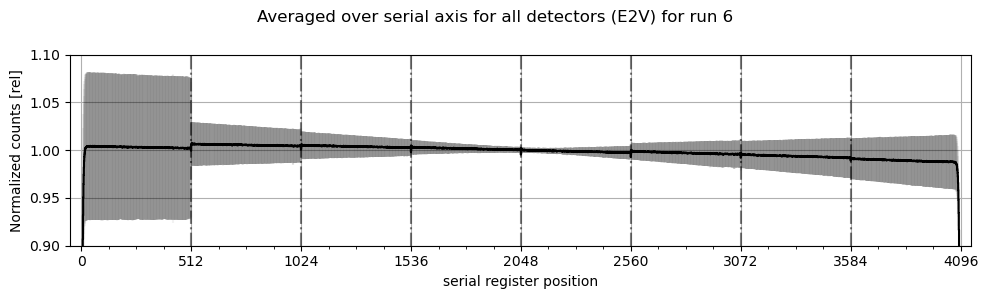

In [28]:
fig = rsu.make1DFigure(E2V_Normed_x,E2V_Normed_x_std,"x","E2V","all detectors",tight=True,normed=True,ylim=[0.9,1.1],threshold=False,figsize=[10,3])
fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/FlatPictureFrames/E2V_wide.jpg",dpi=200)

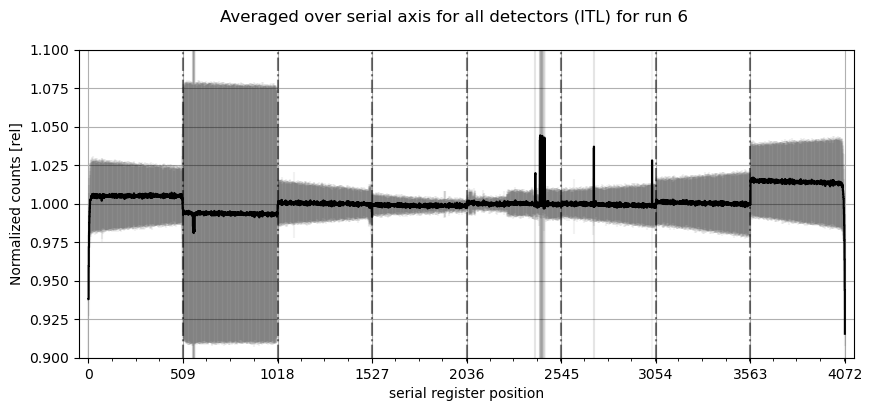

In [29]:
fig = rsu.make1DFigure(ITL_Normed_x,ITL_Normed_x_std,"x","ITL","all detectors",normed=True,ylim=[0.9,1.1],threshold=False)
fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/FlatPictureFrames/ITL_wide.jpg",dpi=200)

### Left Edge - 5 pixel width for E2V, 0 pixel width for ITL

For 1%, there are 16 pixels
For 2%, there are 14 pixels
For 3%, there are 12 pixels
For 4%, there are 10 pixels
For 5%, there are 10 pixels
For 6%, there are 9 pixels
For 7%, there are 9 pixels
For 8%, there are 8 pixels
For 9%, there are 8 pixels
For 10%, there are 8 pixels


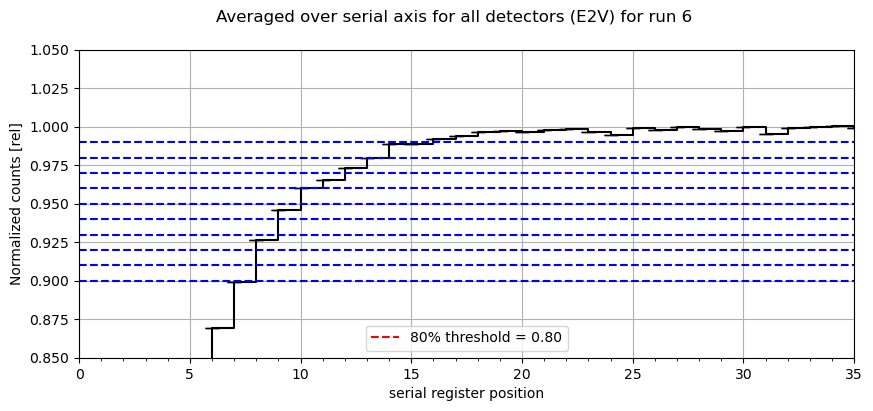

In [9]:
fig = rsu.make1DFigure(E2V_Normed_x,0,"x","E2V","all detectors",edge=True,normed=True,ylim=[0.9,1.02],levels=True)
# fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/FlatPictureFrames/E2V_left.jpg",dpi=200)
rsu.EdgeStatisticsManager(E2V_Normed_x,"serial","left",40)


For 1%, there are 7 pixels
For 2%, there are 4 pixels
For 3%, there are 3 pixels
For 4%, there are 2 pixels
For 5%, there are 1 pixels
For 6%, there are 1 pixels
For 7%, there are 0 pixels
For 8%, there are 0 pixels
For 9%, there are 0 pixels
For 10%, there are 0 pixels


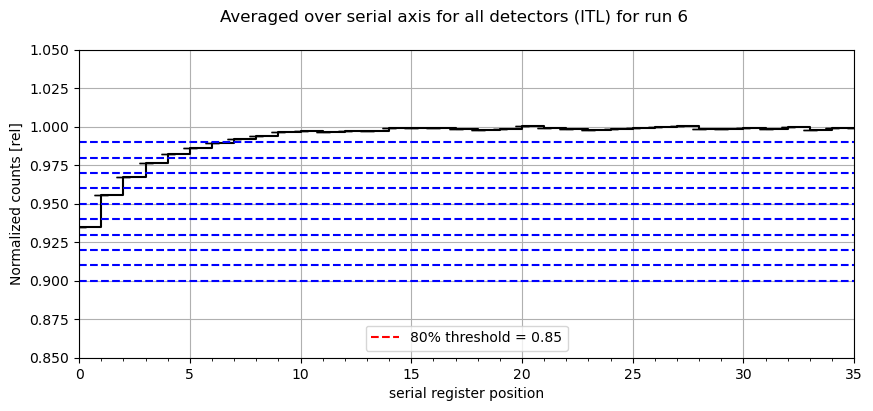

In [10]:
# fig = rsu.make1DFigure(ITL_Normed_x,0,"x","ITL","all detectors",edge=True,normed=True,ylim=[0.2,1.02])
fig = rsu.make1DFigure(ITL_Normed_x+0.008,0,"x","ITL","all detectors",edge=True,normed=True,levels=True)
# fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/FlatPictureFrames/ITL_left.jpg",dpi=200)
rsu.EdgeStatisticsManager(ITL_Normed_x,"serial","left",40)


### Right edge - 5 pixel width for E2V, 0 pixels for ITL

In [25]:
# fig = rsu.make1DFigure(E2V_Normed_x,0,"x","E2V","all detectors",edge=True,normed=True,left=False,levels=True)
rsu.EdgeStatisticsManager(E2V_Normed_x,"serial","right",40)
# fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/FlatPictureFrames/E2V_right.jpg",dpi=200)

For 1%, there are 15 pixels
For 2%, there are 13 pixels
For 3%, there are 12 pixels
For 4%, there are 11 pixels
For 5%, there are 10 pixels
For 6%, there are 9 pixels
For 7%, there are 9 pixels
For 8%, there are 8 pixels
For 9%, there are 8 pixels
For 10%, there are 7 pixels


For 1%, there are 8 pixels
For 2%, there are 5 pixels
For 3%, there are 4 pixels
For 4%, there are 3 pixels
For 5%, there are 2 pixels
For 6%, there are 2 pixels
For 7%, there are 1 pixels
For 8%, there are 1 pixels
For 9%, there are 1 pixels
For 10%, there are 0 pixels


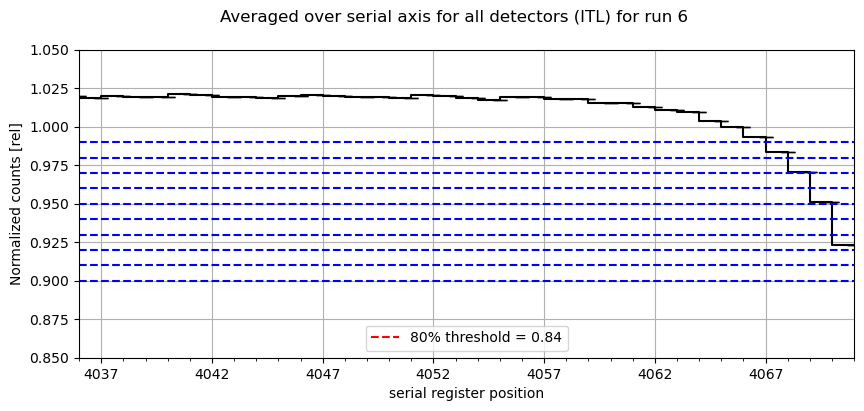

In [12]:
fig = rsu.make1DFigure(ITL_Normed_x,0,"x","ITL","all detectors",edge=True,normed=True,left=False,levels=True)
rsu.EdgeStatisticsManager(ITL_Normed_x,"serial","right",40)
# fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/FlatPictureFrames/ITL_right.jpg",dpi=200)


### Midline - not useful for these purposes

In [ ]:
fig = rsu.make1DFigure(E2V_Normed_x,0,"x","E2V","all detectors",midline=True,normed=True) # This would be useful for y axis only

In [ ]:
fig = rsu.make1DFigure(ITL_Normed_x,0,"x","ITL","all detectors",midline=True,normed=True) # This would be useful for y axis only

## y axis - 4k detectors

### Full range

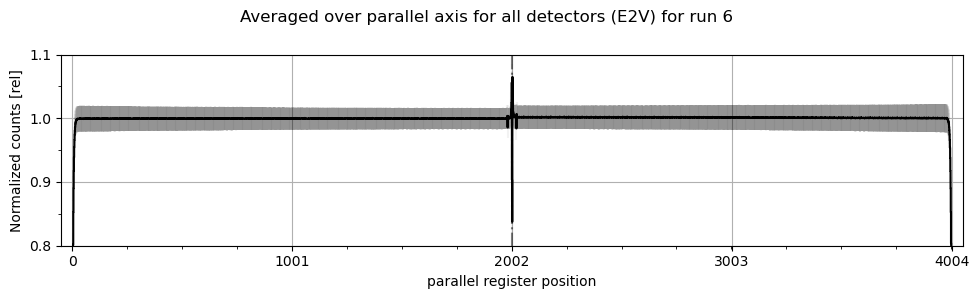

In [16]:
fig = rsu.make1DFigure(E2V_Normed_y,E2V_Normed_y_std,"y","E2V","all detectors",tight=True,normed=True,ylim=[0.8,1.1],threshold=False,figsize=[10,3])
fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/FlatPictureFrames/E2V_parallel_wide.jpg",dpi=200)

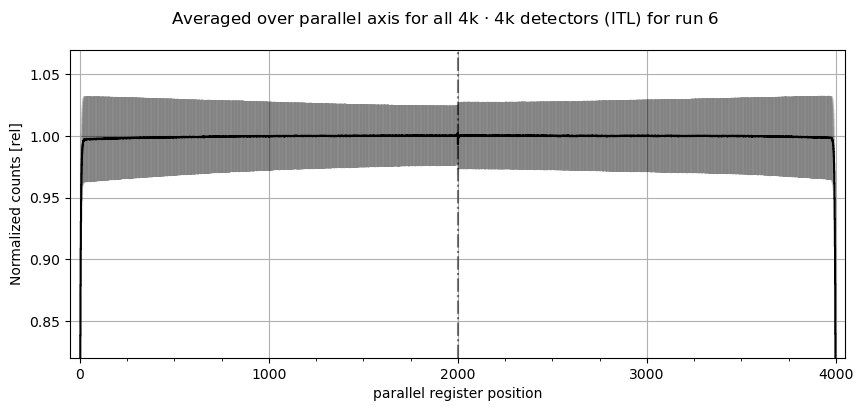

In [37]:
fig = rsu.make1DFigure(ITL_Normed_y,ITL_Normed_y_std,"y",r"ITL","all 4k $\cdot$ 4k detectors",normed=True,ylim=[0.82,1.07],threshold=False)

fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/FlatPictureFrames/ITL_parallel_wide.jpg",dpi=200)


### Left edge - 4-5 pixels below threshold for E2V, 3 for ITL

For 1%, there are 13 pixels
For 2%, there are 11 pixels
For 3%, there are 10 pixels
For 4%, there are 9 pixels
For 5%, there are 8 pixels
For 6%, there are 8 pixels
For 7%, there are 7 pixels
For 8%, there are 7 pixels
For 9%, there are 6 pixels
For 10%, there are 6 pixels


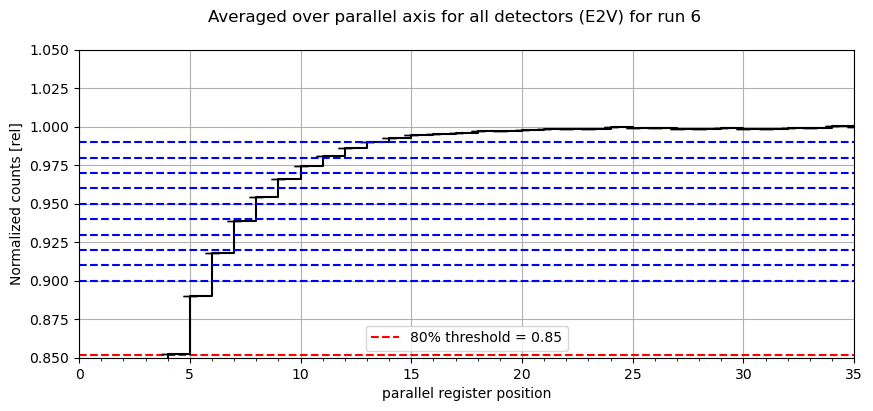

In [21]:
fig = rsu.make1DFigure(E2V_Normed_y,0,"y","E2V","all detectors",edge=True,normed=True,ylim=None,levels=True)
rsu.EdgeStatisticsManager(E2V_Normed_y,"parallel","left",40)

# fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/FlatPictureFrames/E2V_parallel_bottom.jpg",dpi=200)


For 1%, there are 14 pixels
For 2%, there are 11 pixels
For 3%, there are 10 pixels
For 4%, there are 8 pixels
For 5%, there are 8 pixels
For 6%, there are 7 pixels
For 7%, there are 6 pixels
For 8%, there are 6 pixels
For 9%, there are 6 pixels
For 10%, there are 5 pixels


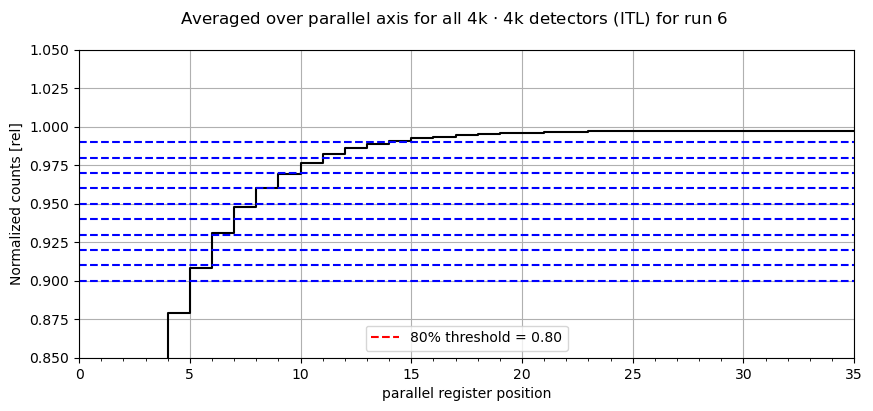

In [15]:
fig = rsu.make1DFigure(ITL_Normed_y,0,"y","ITL","all 4k $\cdot$ 4k detectors",edge=True,normed=True,levels=True)
rsu.EdgeStatisticsManager(ITL_Normed_y,"parallel","left",40)

# fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/FlatPictureFrames/ITL_parallel_bottom.jpg",dpi=200)


### Right edge - 4-5 pixels below threshold for E2V, 3 pixels for ITL

For 1%, there are 13 pixels
For 2%, there are 11 pixels
For 3%, there are 10 pixels
For 4%, there are 9 pixels
For 5%, there are 8 pixels
For 6%, there are 8 pixels
For 7%, there are 7 pixels
For 8%, there are 7 pixels
For 9%, there are 6 pixels
For 10%, there are 6 pixels


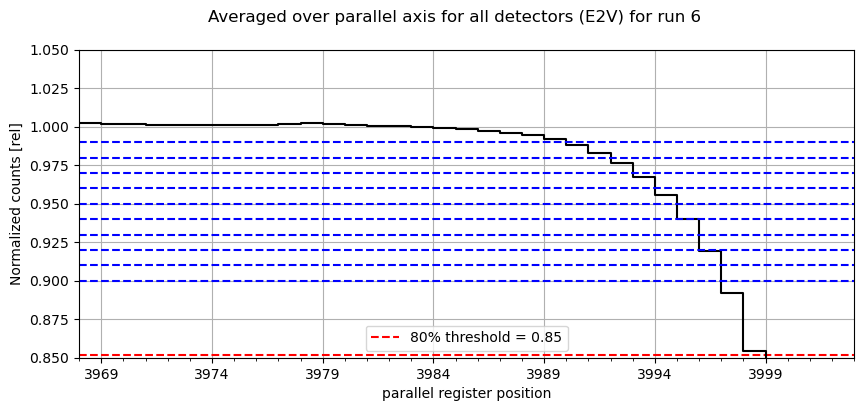

In [17]:
fig = rsu.make1DFigure(E2V_Normed_y,0,"y","E2V","all detectors",edge=True,normed=True,left=False,levels=True)
rsu.EdgeStatisticsManager(E2V_Normed_y,"parallel","right",40)

# fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/FlatPictureFrames/E2V_parallel_top.jpg",dpi=200)


For 1%, there are 14 pixels
For 2%, there are 11 pixels
For 3%, there are 9 pixels
For 4%, there are 8 pixels
For 5%, there are 8 pixels
For 6%, there are 7 pixels
For 7%, there are 6 pixels
For 8%, there are 6 pixels
For 9%, there are 5 pixels
For 10%, there are 5 pixels


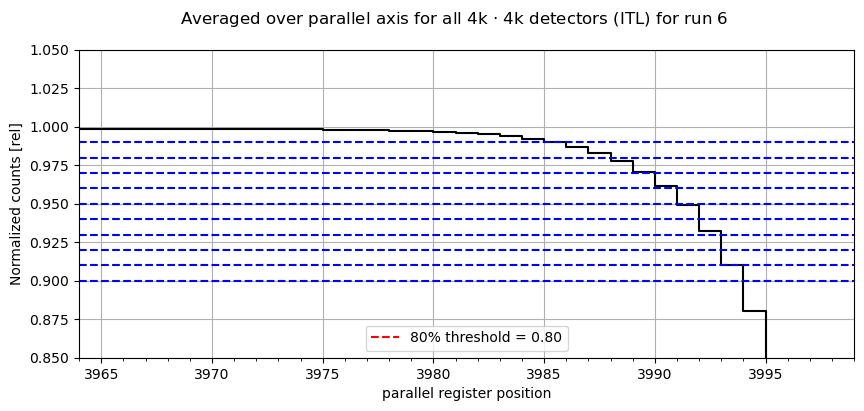

In [18]:
fig = rsu.make1DFigure(ITL_Normed_y,0,"y","ITL","all 4k $\cdot$ 4k detectors",edge=True,normed=True,left=False,levels=True)
rsu.EdgeStatisticsManager(ITL_Normed_y,"parallel","right",40)

# fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/FlatPictureFrames/ITL_parallel_top.jpg",dpi=200)


### Midline break - fluctuation of ~20% for E2V, ~1% for ITL

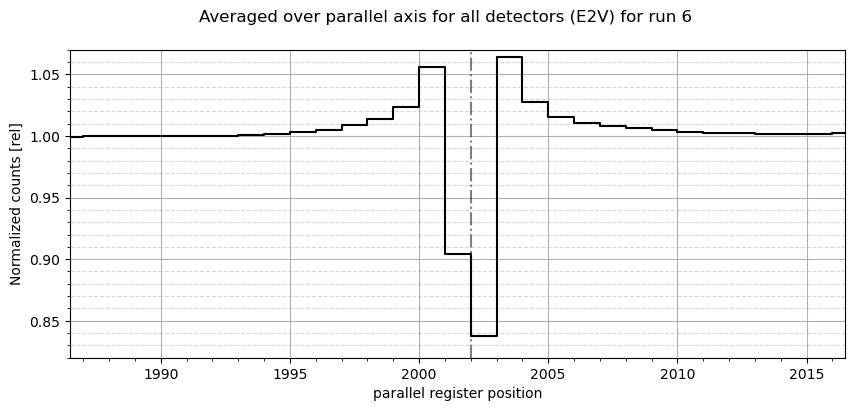

In [4]:
fig = rsu.make1DFigure(E2V_Normed_y,0,"y","E2V","all detectors",midline=True,normed=True,ylim=[0.82,1.07],threshold=False,minor=True) # This would be useful for y axis only
# fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/FlatPictureFrames/E2V_parallel_midline.jpg",dpi=200)


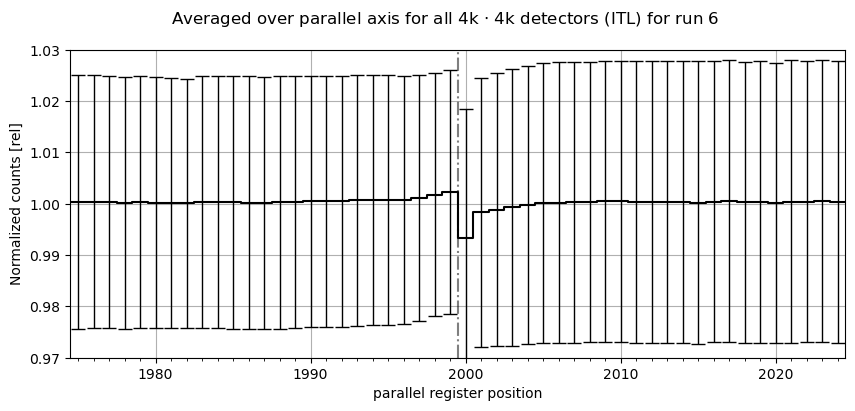

In [41]:
fig = rsu.make1DFigure(ITL_Normed_y,ITL_Normed_y_std,"y","ITL","all 4k $\cdot$ 4k detectors",midline=True,normed=True,ylim=[0.97,1.03],threshold=False) # This would be useful for y axis only
# fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/FlatPictureFrames/ITL_parallel_midline_1.jpg",dpi=200)
# fig = rsu.make1DFigure(ITL_Normed_y,0,"y","ITL","all 4k $\cdot$ 4k detectors",midline=True,normed=True,ylim=[0.9875,1.002]) # This would be useful for y axis only
# fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/FlatPictureFrames/ITL_parallel_midline_2.jpg",dpi=200)


## y axis - edge ITL detectors

### Full range

In [ ]:
fig = rsu.make1DFigure(ITL_Normed_y_edge,0,"y","ITL","edge detectors",midline=False,normed=True)
# fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/FlatPictureFrames/ITL_edge_parallel_wide.jpg",dpi=200)



### Left edge - pixtureframe size of 1 pixel

For 1%, there are 11 pixels
For 2%, there are 8 pixels
For 3%, there are 7 pixels
For 4%, there are 6 pixels
For 5%, there are 5 pixels
For 6%, there are 4 pixels
For 7%, there are 4 pixels
For 8%, there are 3 pixels
For 9%, there are 3 pixels
For 10%, there are 3 pixels


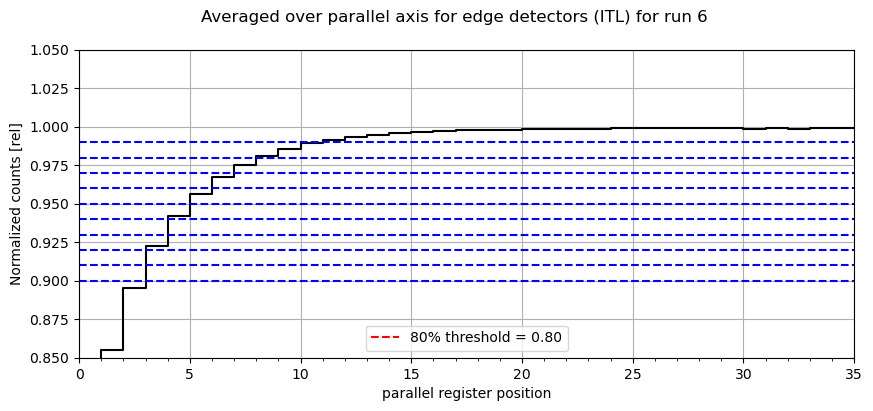

In [20]:
fig = rsu.make1DFigure(ITL_Normed_y_edge,0,"y","ITL","edge detectors",edge=True,normed=True,levels=True)
rsu.getEdgeCutoffs(ITL_Normed_y_edge,adjustment=1,side="left",endpoint=40)
# fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/FlatPictureFrames/ITL_edge_parallel_bottom.jpg",dpi=200)


### Right edge - pictureframe size of 1 pixel

For 1%, there are 11 pixels
For 2%, there are 8 pixels
For 3%, there are 7 pixels
For 4%, there are 6 pixels
For 5%, there are 5 pixels
For 6%, there are 5 pixels
For 7%, there are 4 pixels
For 8%, there are 4 pixels
For 9%, there are 3 pixels
For 10%, there are 3 pixels


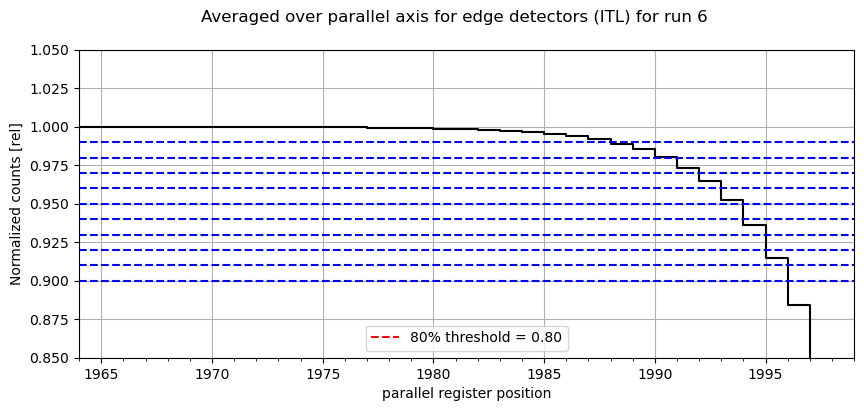

In [22]:
fig = rsu.make1DFigure(ITL_Normed_y_edge,0,"y","ITL","edge detectors",edge=True,left=False,normed=True,levels=True)
# fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/FlatPictureFrames/ITL_edge_parallel_top.jpg",dpi=200)
rsu.getEdgeCutoffs(ITL_Normed_y_edge,adjustment=1,side="right",endpoint=40)


### Midline break - not useful for these purposes

In [ ]:
fig = rsu.make1DFigure(ITL_Normed_y_edge,0,"y","ITL","edge detectors",midline=True,normed=True)

# Graph of results from edge study

In [16]:
percent_levels = np.arange(1,11)
E2V_Serial = [15.5,13.5,12,10.5,10,9,9,8,8,7.5]
E2V_Parallel = [13,11,10,9,8,8,7,7,6,6]
ITL_Serial = [7.5,4.5,3.5,2.5,1.5,1.5,0.5,0.5,0.5,0]
ITL_Parallel = [14,11,9.5,8,8,7,6,6,5.5,5]
ITL_Parallel_edge = [11,8,7,6,5,4.5,4,3.5,3,3]

data = np.array([E2V_Serial,E2V_Parallel,ITL_Serial,ITL_Parallel,ITL_Parallel_edge])
labels = ["E2V Serial",'E2V Parallel',"ITL 4k x 4k Serial","ITL 4k x 4k Parallel","ITL Corner Parallel"]
lines = ['solid','dashdot','solid','dashdot','dashdot']
colors = ['red','red','blue','blue','green']

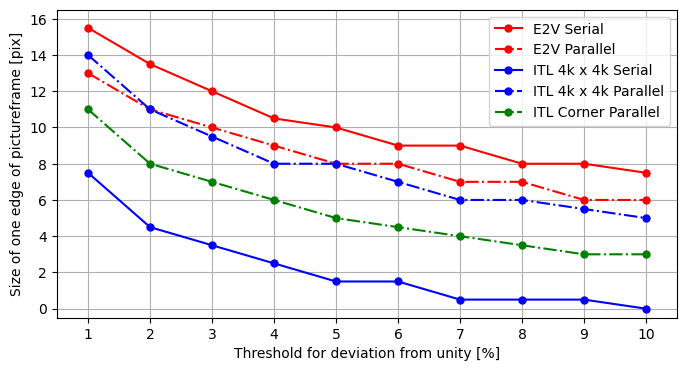

In [17]:
fig = rsu.linePlot(data,labels,lines,colors,ylims=(-0.5,16.5),yrange=np.arange(0,17,step=2),
                   xlabel="Threshold for deviation from unity [%]",ylabel="Size of one edge of pictureframe [pix]")

fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/PictureFrameHeatmaps/AllLinePlot.jpg",dpi=200)

fig.show()

# Now do the same for the total pictureframe size, total pixels impacted, and the total area of the detector impacted

In [12]:
# compute total pictureframe size
total_data = 2*data
# compute total pixels impacted
detector_dimensions = np.array(10*[4004,4096,4000,4072,4072]).reshape(10,5) # dimension of the E2V serial, E2V parallel, ITL Serial, ITL parallel 4k x 4k, and ITL Parallel 4k x 2k axes - swapped to properly calculate length of other edge
total_pixels = total_data * detector_dimensions.T
# compute total area of detector impacted
detector_areas = np.array([4004*4096,4004*4096,4072*4000,4072*4000,2000*4072])
total_areas = np.zeros(0)
for row1,row2 in zip(total_pixels,detector_areas):
    total_areas = np.append(total_areas,row1/row2 * 100)
total_areas = total_areas.reshape((5,10))

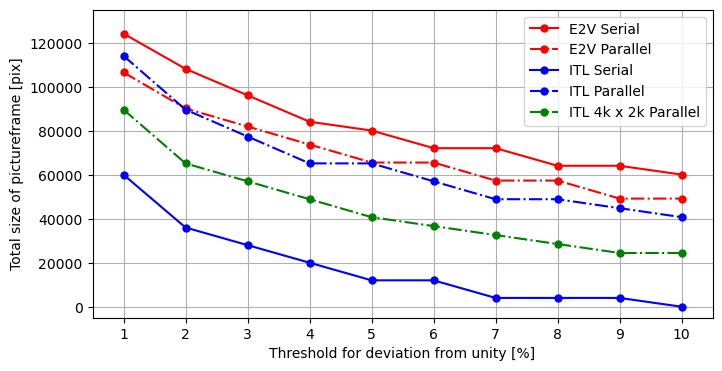

In [23]:
fig = rsu.linePlot(total_pixels,labels,lines,colors,xlims=(0.5,10.5),yrange=np.arange(0,1.4E5,step=2E4),
                   ylims=(-0.5E4,1.35E5),xlabel="Threshold for deviation from unity [%]",ylabel="Total size of pictureframe [pix]")

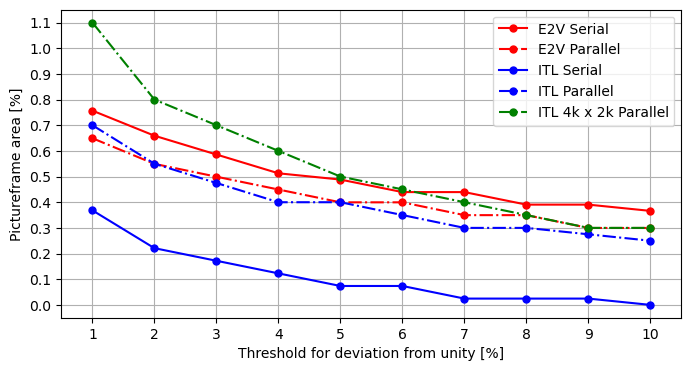

In [24]:
fig = rsu.linePlot(total_areas,labels,lines,colors)

# Now, three heatmaps
- one for E2V
- One for 4k x 4k ITL
- One for 4k x 2k ITL

In [33]:
E2V_areas = rsu.calculateMatrix(total_areas[0],total_areas[1])
ITL_areas = rsu.calculateMatrix(total_areas[2],total_areas[3])
ITL_edge_areas = rsu.calculateMatrix(total_areas[2],total_areas[4])

E2V_pixels = rsu.calculateMatrix(data[0],data[1])
ITL_pixels = rsu.calculateMatrix(data[2],data[3])
ITL_edge_pixels = rsu.calculateMatrix(data[2],data[4])

## ITL

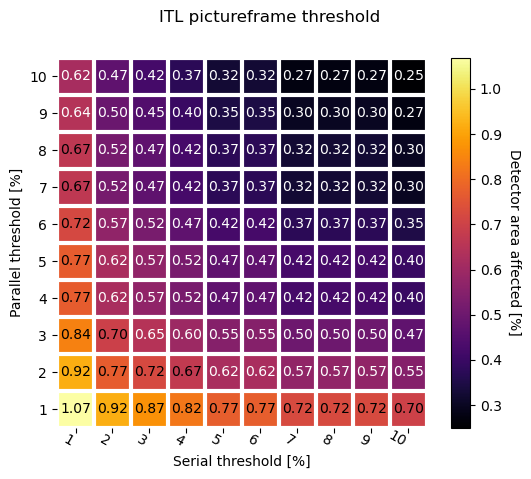

In [26]:
fig, ax = plt.subplots()
fig.suptitle("ITL pictureframe threshold")
im, cbar = rsu.heatmap(ITL_areas, row_labels = percent_levels, col_labels = percent_levels,
        ax = ax, cmap = "inferno", cbarlabel = "Detector area affected [%]",
                   xlabel="Serial threshold [%]",ylabel="Parallel threshold [%]")
txts = rsu.annotate_heatmap(im,data=ITL_areas,textcolors=("white","black"))
fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/PictureFrameHeatmaps/ITL.jpg",dpi=200)

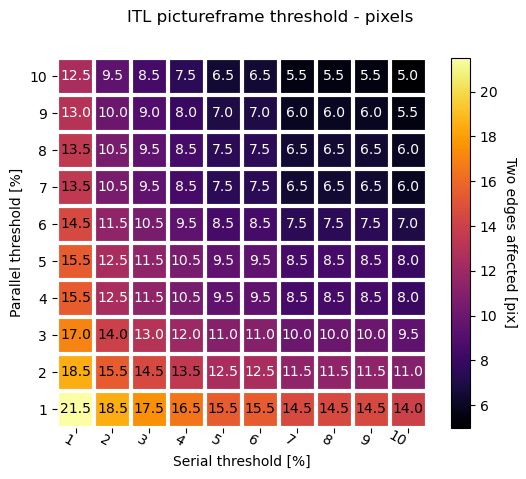

In [51]:
fig, ax = plt.subplots()
fig.suptitle("ITL pictureframe threshold - pixels")
im, cbar = rsu.heatmap(ITL_pixels, row_labels = percent_levels, col_labels = percent_levels,
        ax = ax, cmap = "inferno", cbarlabel = "Two edges affected [pix]",
                   xlabel="Serial threshold [%]",ylabel="Parallel threshold [%]")
txts = rsu.annotate_heatmap(im,data=ITL_pixels,textcolors=("white","black"),valfmt='{x:.1f}')
fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/PictureFrameHeatmaps/ITL_pix.jpg",dpi=200)

## E2V

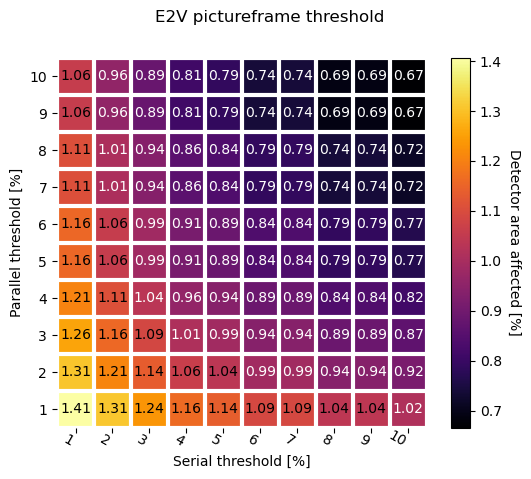

In [27]:
fig, ax = plt.subplots()
fig.suptitle("E2V pictureframe threshold")
im, cbar = rsu.heatmap(E2V_areas, row_labels = percent_levels, col_labels = percent_levels,
                       ax = ax, cmap = "inferno", cbarlabel = "Detector area affected [%]",
                   xlabel="Serial threshold [%]",ylabel="Parallel threshold [%]")
txts = rsu.annotate_heatmap(im,data=E2V_areas,textcolors=("white","black"))
fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/PictureFrameHeatmaps/E2V.jpg",dpi=200)

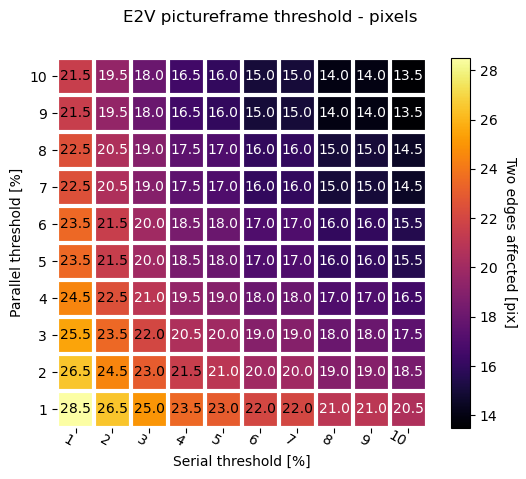

In [50]:
fig, ax = plt.subplots()
fig.suptitle("E2V pictureframe threshold - pixels")
im, cbar = rsu.heatmap(E2V_pixels, row_labels = percent_levels, col_labels = percent_levels,
        ax = ax, cmap = "inferno", cbarlabel = "Two edges affected [pix]",
                   xlabel="Serial threshold [%]",ylabel="Parallel threshold [%]")
txts = rsu.annotate_heatmap(im,data=E2V_pixels,textcolors=("white","black"),valfmt='{x:.1f}')
fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/PictureFrameHeatmaps/E2V_pix.jpg",dpi=200)

## ITL Edge

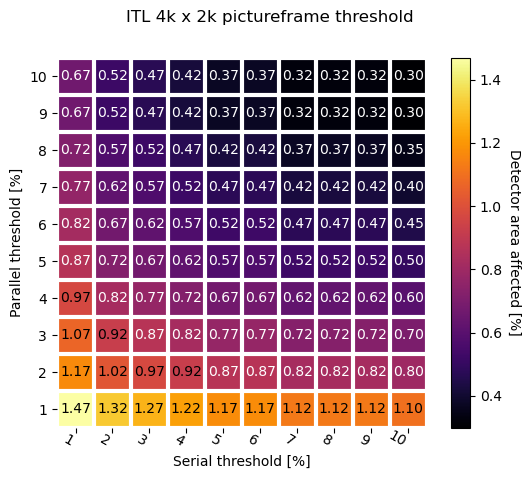

In [28]:
fig, ax = plt.subplots()
fig.suptitle("ITL 4k x 2k pictureframe threshold")
im, cbar = rsu.heatmap(ITL_edge_areas, row_labels = percent_levels, col_labels = percent_levels,
        ax = ax, cmap = "inferno", cbarlabel = "Detector area affected [%]",
                   xlabel="Serial threshold [%]",ylabel="Parallel threshold [%]")
txts = rsu.annotate_heatmap(im,data=ITL_edge_areas,textcolors=("white","black"))
fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/PictureFrameHeatmaps/ITL_edge.jpg",dpi=200)

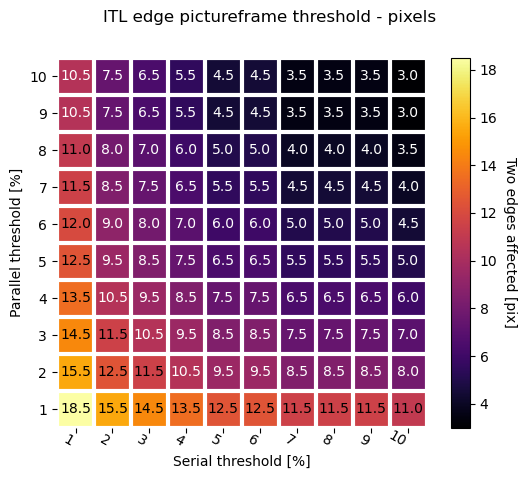

In [49]:
fig, ax = plt.subplots()
fig.suptitle("ITL edge pictureframe threshold - pixels")
im, cbar = rsu.heatmap(ITL_edge_pixels, row_labels = percent_levels, col_labels = percent_levels,
        ax = ax, cmap = "inferno", cbarlabel = "Two edges affected [pix]",
                   xlabel="Serial threshold [%]",ylabel="Parallel threshold [%]")
txts = rsu.annotate_heatmap(im,data=ITL_edge_pixels,textcolors=("white","black"),valfmt='{x:.1f}')
fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/PictureFrameHeatmaps/ITL_edge_pix.jpg",dpi=200)

In [109]:
collections = 'LSSTCam/raw/all,LSSTCam/calib'.split(",") # Defining collections (that are ignored by below kernel)
butler = daf_butler.Butler('/repo/ir2',collections=collections) # Initializing a butler with the ir2 path and the above collections
registry = butler.registry
base_dir = "u/lsstccs/"
collection = base_dir+'flat'+"_"+run[0]
kwargs={
        "datasetType": 'flat',
        "collections": collection,
        "where":
        """
        instrument='LSSTCam' and 
        detector = {var}
        """.format(var=100)}
    
datasetRefs = list(registry.queryDatasets(**kwargs))

# rsu.getImage("flat",run[0],100)

# Statistics for one detector

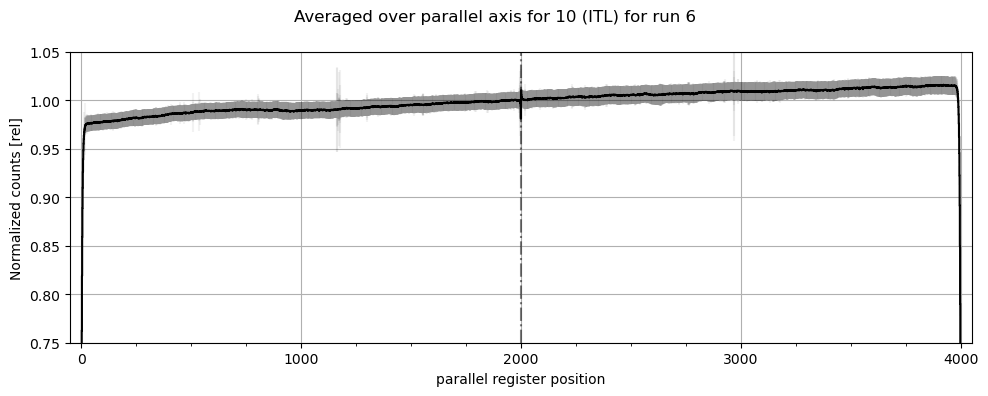

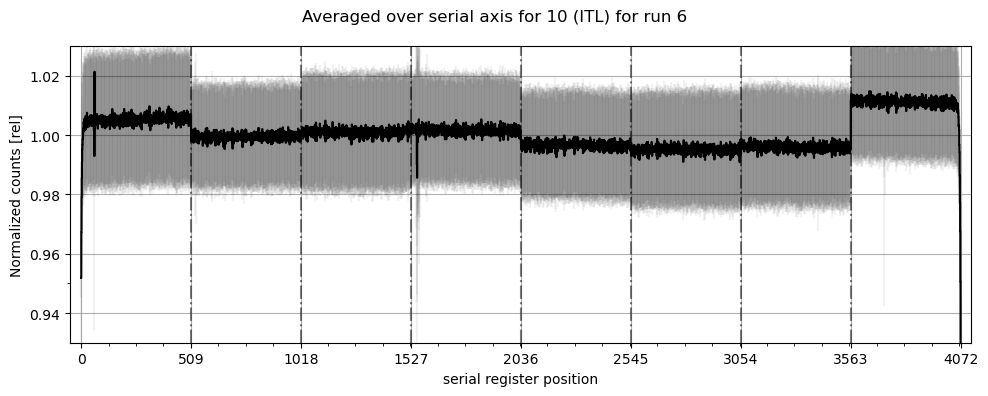

In [8]:
detector=10
ylim = (0.75,1.05)
fig = rsu.generate1DStatistics_oneDetector(img,run[0],detector,'y',norm=True,median=True,threshold=False,ylim=ylim)
fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/IndividualDetectorFigs/Detector_{}_parallel.jpg".format(detector),dpi=180)
fig = rsu.generate1DStatistics_oneDetector(img,run[0],detector,'x',norm=True,median=True,threshold=False,ylim=(0.93,1.03))
fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/IndividualDetectorFigs/Detector_{}_serial.jpg".format(detector),dpi=180)

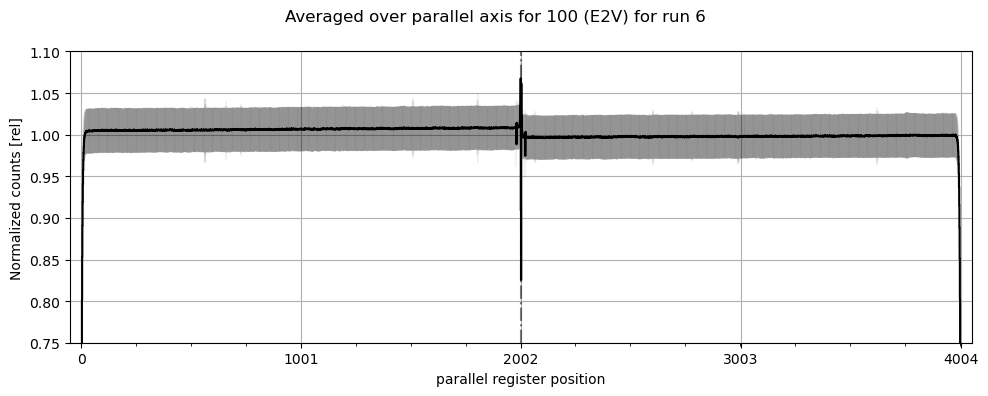

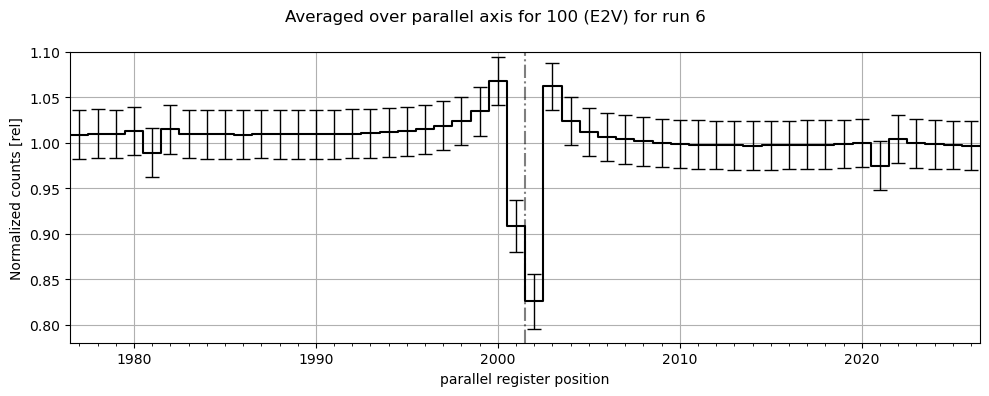

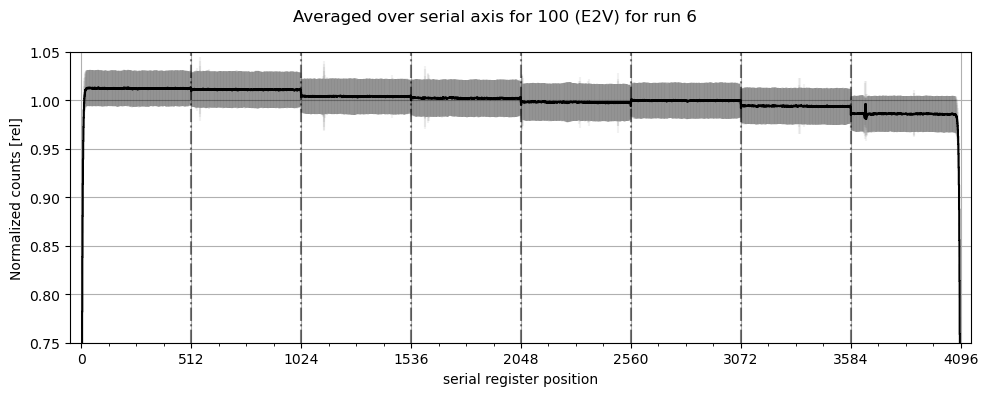

In [7]:
detector=100
fig = rsu.generate1DStatistics_oneDetector(img,run[0],detector,'y',norm=True,median=True,threshold=False,ylim=(0.75,1.1))
fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/IndividualDetectorFigs/Detector_{}_parallel.jpg".format(detector),dpi=180)
fig = rsu.generate1DStatistics_oneDetector(img,run[0],detector,'y',norm=True,median=True,threshold=False,ylim=(0.78,1.1),midline=True)
fig = rsu.generate1DStatistics_oneDetector(img,run[0],detector,'x',norm=True,median=True,threshold=False,ylim=ylim)
fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/IndividualDetectorFigs/Detector_{}_serial.jpg".format(detector),dpi=180)

# Detectors flagged as interesting before - now look at the 1d counts

In [5]:
detector_arr = [  0,  20,  27,  65, 123, 161, 168, 188, 189, 190, 193, 194, 197,198, 201, 202]

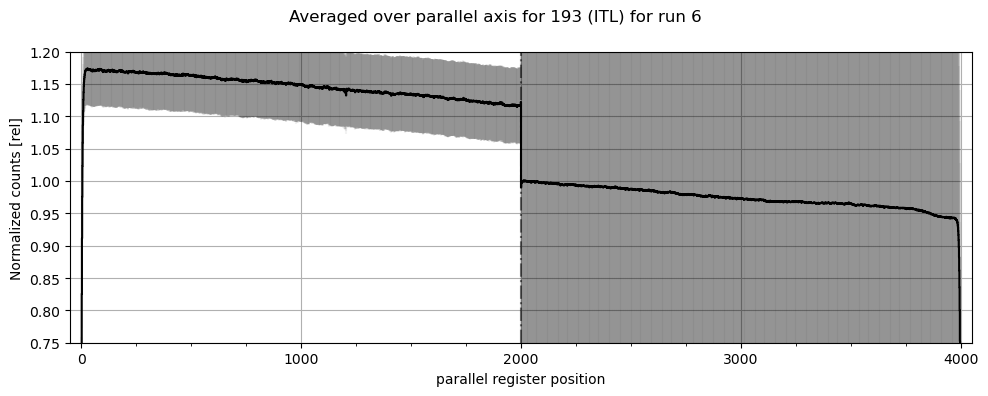

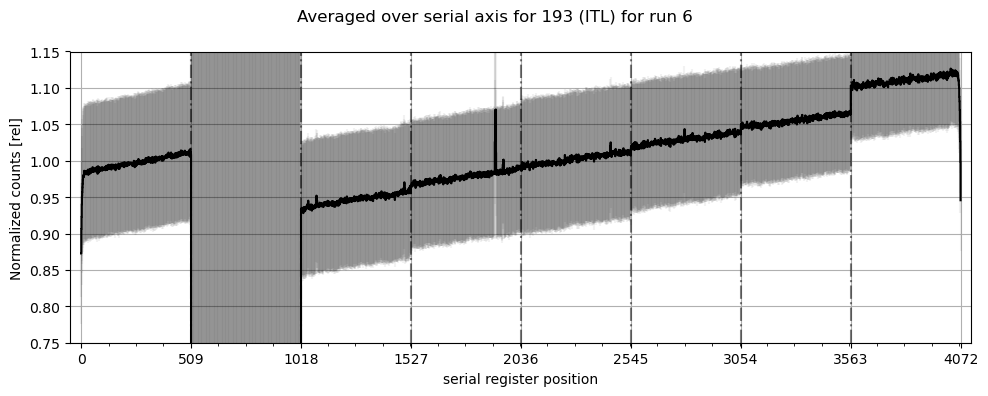

<Figure size 640x480 with 0 Axes>

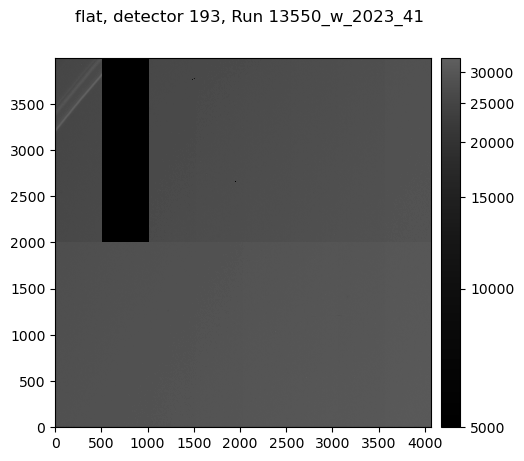

In [23]:
for det in detector_arr[-6:-5]:
    fig = rsu.generate1DStatistics_oneDetector(img,run[3],det,'y',norm=True,median=True,threshold=False,ylim=(0.75,1.2))
    fig.show()
    fig = rsu.generate1DStatistics_oneDetector(img,run[3],det,'x',norm=True,median=True,threshold=False,ylim=(0.75,1.15))
    fig.show()
    fig = rsu.makeSimpleImg(img,run[3],det)
    fig.show()
    

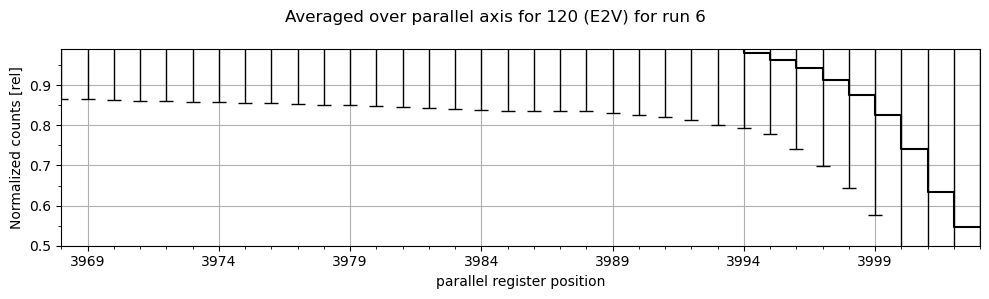

In [20]:
fig = rsu.generate1DStatistics_oneDetector(img,run[3],120,'y',tight=True,norm=True,median=True,edge=True,threshold=False,ylim=(0.5,0.99),figsize=[10,3],left=False)
# fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/IndividualDetectorFigs/Detector100Presentation.jpg",dpi=180)

In [44]:
image = rsu.getImage('flat',run[3],120)
a = image.getMetadata()
a.toDict()["LSST GAIN C01"]

1.13225

In [7]:
print(10*"-","ITL",10*"-")
rsu.getEdgeCutoffs(ITL_Normed_y,adjustment=1,side="mid",endpoint=50)
print(10*"-","E2V",10*"-")
rsu.getEdgeCutoffs(E2V_Normed_y,adjustment=1,side="mid",endpoint=50)

---------- ITL ----------
For 1%, there are 0 pixels
For 2%, there are 0 pixels
For 3%, there are 0 pixels
For 4%, there are 0 pixels
For 5%, there are 0 pixels
For 6%, there are 0 pixels
For 7%, there are 0 pixels
For 8%, there are 0 pixels
For 9%, there are 0 pixels
For 10%, there are 0 pixels
---------- E2V ----------
For 1%, there are 11 pixels
For 2%, there are 6 pixels
For 3%, there are 4 pixels
For 4%, there are 4 pixels
For 5%, there are 4 pixels
For 6%, there are 3 pixels
For 7%, there are 2 pixels
For 8%, there are 2 pixels
For 9%, there are 2 pixels
For 10%, there are 1 pixels


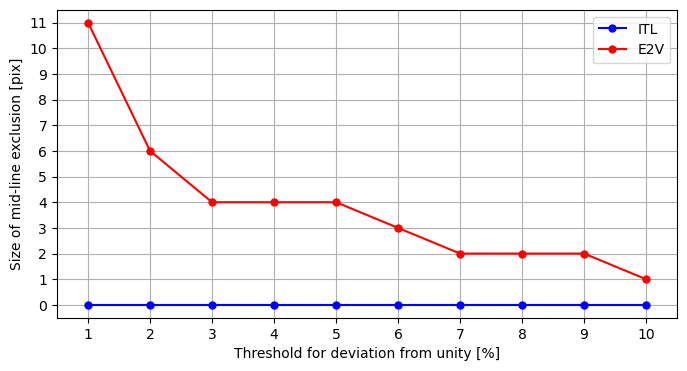

In [20]:
E2V_cutoffs = [11,6,4,4,4,3,2,2,2,1]
ITL_cutoffs = 10*[0]
arrs = [ITL_cutoffs,E2V_cutoffs]
labels = ["ITL","E2V"]
lines = ["-","-"]
colors = ["blue","red"]


fig = rsu.linePlot(arrs,labels,lines,colors,ylims=(-0.5,11.5),yrange=np.arange(0,12,step=1),
                   xlabel="Threshold for deviation from unity [%]",ylabel="Size of mid-line exclusion [pix]")

fig.savefig("/home/s/seanmacb/Run6Comparisons/Figures/PictureFrameHeatmaps/AllLinePlot_midline.jpg",dpi=200)

fig.show()

In [22]:
image_6b = rsu.getImage("flat","13550_w_2023_41",100)

In [25]:
print(image_6b.getMetadata())

CALIB_CREATION_DATE = "2023-11-16"
CALIB_CREATION_TIME = "14:28:52 PST"
RUNNUM = "13550"
// The Run Number
CCD_MANU = "E2V"
// CCD Manufacturer
CCD_TYPE = "CCD250"
// CCD Model Number
TESTTYPE = "SFLAT_HI"
// BIAS, DARK, FE55, FLAT, LAMBDA, PERSISTENCE, SP
IMGTYPE = "FLAT"
// BIAS, DARK, FE55, FLAT, FLAT_<lam>, SPOT, PPUMP
DETSIZE = "[1:4096,1:4004]"
BINX = 1
// [pixels] binning along X axis
BINY = 1
// [pixels] binning along Y axis
CCDGAIN = 1.0000000000000
// Rough guess at overall system gain (e-/DNB)
CCDNOISE = 10.000000000000
// Rough guess at system noise (e- rms)
CCDSLOT = "S01"
// The CCD Slot
RAFTBAY = "R23"
// The RAFT Bay
FIRMWARE = "3139500e"
// DAQ firmware version (Hex)
PLATFORM = "ir2-camera"
// DAQ platform version
CONTNUM = "18910e0c"
// REB serial # (Hex)
DAQVERS = "R5-V6.9 2023-09-11T17:05:01Z (9eb7c3ed)"
// DAQ version
DAQPART = "camera"
// DAQ partition
DAQFOLD = "raw"
// DAQ folder the image was initially created in
OBSANNOT = ""
// DAQ image annotation
CAMCODE = 

In [10]:
! pwd

/home/s/seanmacb/Run6Comparisons


# Testing below

In [ ]:
# np.reshape(E2V_Normed_y,((117,4004)))

In [ ]:
len(E2V_Normed_y),len(ITL_Normed_y)

## Testing here

In [ ]:
arr,manu_type = rsu.getArray(img[0],run[0],detector)
# Fix array
arr,axis = rsu.fixArray(arr,axis='x')
# Compute averages
# avg_arr,std_arr = computeAverageArr(arr)

In [ ]:
arr.T

## Testing here

In [ ]:
run_number = ["13401_w_2023_24","13550_w_2023_41"]
defect_datasets=["eoDarkDefects","eoBrightDefects"]
defect_dataset_path=["eo_dark_defects","eo_bright_defects"]

In [ ]:
collections = 'LSSTCam/raw/all,LSSTCam/calib'.split(",") # Defining collections (that are ignored by below kernel)
butler = daf_butler.Butler('/repo/ir2',collections=collections) # Initializing a butler with the ir2 path and the above collections
registry = butler.registry

In [ ]:
# Update to a new mask plane for the bright and dark defects
# Have to make a new mask plane first...

# help(image.getMask().removeMaskPlane("BAD"))

# len(image.getMask().getMaskPlaneDict())

In [29]:
detector=100

In [30]:
image = rsu.getImage(img[0],run[0],detector)

IndexError: list index out of range

In [ ]:
# print(image.getMetadata())

In [ ]:
    '''
    fig,ax = plt.subplots(figsize=[8,6])

    # if y_ax == 'log':
    #     ax.semilogy()
    # elif y_ax != 'linear':
    #     print("y_ax keyword not set correctly")
    #     return -1        
    
    n, bins, patches = ax.hist(arr, bins=bin_num, facecolor=face_color, edgecolor=edgecolor, linewidth=lw, alpha=alpha,density=True)

    n = n.astype('int') # it MUST be integer# Good old loop. Choose colormap of your taste
    
    # for i in range(len(patches)):
    #     patches[i].set_facecolor(plt.cm.plasma(n[i]/max(n)))# Make one bin stand out   
    
    # patches[47].set_fc('red') # Set color
    # patches[47].set_alpha(1) # Set opacity# Add annotation
    # plt.annotate('Important Bar!', xy=(0.57, 175), xytext=(2, 130), fontsize=15, arrowprops={'width':0.4,'headwidth':7,'color':'#333333'})# Add title and labels with custom font sizes
    
    ax.set_title('Distribution of pixel values from detector {var1} ({var3}) {var4} image, run {var2}'.format(var1=detector,var2=run_num,var3=get_serial_from_number([detector])[0],var4=img), fontsize=12)
    ax.set_xlabel('Counts [e-]', fontsize=10)
    ax.set_ylabel('Normalized counts [# of pixels]', fontsize=10)


    if fit_norm:
        mu_kwargs = {
            "color":"green",
            "ls":"--"
        }
        sigma_kwargs = {
            'color':"blue"
        }
        # Fit a normal distribution to the data:
        mu, std = norm.fit(arr)
        # Plot the PDF.
        xmin, xmax = xlim
        x = np.linspace(xmin, xmax, 1000)
        p = norm.pdf(x, mu, std )
        ax.plot(x, p, 'k', linewidth=2)
        ax.axvline(mu,**mu_kwargs)
        for num in range(1,n_sig+1):
            ax.axvline(mu+num*std,alpha=1/num,**sigma_kwargs)
            ax.axvline(mu-num*std,alpha=1/num,**sigma_kwargs)
    
    # title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)

    # print(max(p))

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    plt.show()
    return
    '''